In [1]:
# ===============================================
# Preprocesamiento y modelo para weatherAUS.csv (Actualizado con secuencias temporales)
# ===============================================
# https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau



In [3]:
# -------------------------------
# 1. Cargar dataset
# -------------------------------
file_path = "/content/weatherAUS.csv"  # Ajusta la ruta si es necesario
df = pd.read_csv(file_path)

# Filtrar para una ubicación específica (Sydney)
df = df[df['Location'] == 'Sydney'].copy()

# Mostrar estructura inicial
print("Columnas:", df.columns)
print("Filas:", len(df))
print(df.head())

# Detectar columna de fecha
date_col = 'Date'

# Convertir a datetime
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
df = df.set_index(date_col).sort_index()

# Detectar columna objetivo (MaxTemp)
target_col = 'MaxTemp'
if target_col not in df.columns:
    raise ValueError(f"Columna {target_col} no encontrada en el dataset filtrado")

# Seleccionar todas las columnas numéricas como características
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col not in num_cols:
    raise ValueError(f"La columna objetivo {target_col} no es numérica")
feature_cols = num_cols  # Usar todas las columnas numéricas como características
print(f"Características seleccionadas: {feature_cols}")



Columnas: Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')
Filas: 3344
             Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
30176  2008-02-01   Sydney     19.5     22.4      15.6          6.2       0.0   
30177  2008-02-02   Sydney     19.5     25.6       6.0          3.4       2.7   
30178  2008-02-03   Sydney     21.6     24.5       6.6          2.4       0.1   
30179  2008-02-04   Sydney     20.2     22.8      18.8          2.2       0.0   
30180  2008-02-05   Sydney     19.7     25.7      77.4          NaN       0.0   

      WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
30176         NaN            NaN          S  ...

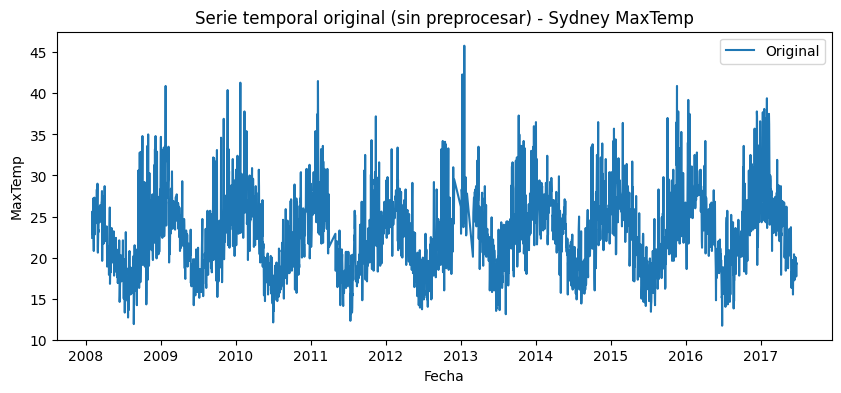

In [4]:
# -------------------------------
# 2. Visualización inicial (sin preprocesar)
# -------------------------------
plt.figure(figsize=(10, 4))
plt.plot(df.index, df[target_col], label="Original")
plt.xlabel("Fecha")
plt.ylabel(target_col)
plt.title("Serie temporal original (sin preprocesar) - Sydney MaxTemp")
plt.legend()
plt.show()


In [5]:
# -------------------------------
# 3. Reindexar frecuencia diaria + interpolar
# -------------------------------
df = df.dropna(subset=[target_col] + feature_cols)
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq="D")
series = df.reindex(full_index)
for col in [target_col] + feature_cols:
    series[col] = series[col].interpolate(method="time", limit_direction="both")

# Eliminar cualquier NaN restante
series = series.dropna(subset=[target_col] + feature_cols)

print(f"Rango de fechas después de preprocesamiento: {series.index.min()} a {series.index.max()}")
print(f"Número de días: {len(series)}")



Rango de fechas después de preprocesamiento: 2010-10-20 00:00:00 a 2017-06-25 00:00:00
Número de días: 2441


In [6]:
# -------------------------------
# 4. Normalización
# -------------------------------
def featureNormalize(X):
    X_norm = X.copy()
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    X_norm = (X - mu) / (sigma + 1e-8)  # Evitar división por cero
    return X_norm, mu, sigma

X = series[feature_cols].values  # Matriz (n_samples, n_features)
y = series[[target_col]].values  # Matriz (n_samples, 1)

X_norm, mu_x, sigma_x = featureNormalize(X)

# Normalizar y usando los parámetros de la feature target
target_idx = feature_cols.index(target_col)
mu_y = mu_x[target_idx]
sigma_y = sigma_x[target_idx]
y_norm = (y - mu_y) / (sigma_y + 1e-8)



In [7]:
# -------------------------------
# 5. Crear secuencias temporales (ventana de 30 pasos pasados)
# -------------------------------
def create_sequences(X, y, seq_length=30):
    xs, ys = [], []
    for i in range(seq_length, len(X)):
        xs.append(X[i-seq_length:i])
        ys.append(y[i])
    return np.array(xs), np.array(ys)

seq_length = 30
X_seq, y_seq = create_sequences(X_norm, y_norm, seq_length)



In [8]:
# -------------------------------
# 6. División 80/20
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, shuffle=False  # Sin mezclar para series temporales
)

print(f"\nTotal de muestras (después de secuencias): {len(X_seq)}")
print(f"Muestras de entrenamiento: {len(X_train)} ({len(X_train)/len(X_seq)*100:.1f}%)")
print(f"Muestras de prueba: {len(X_test)} ({len(X_test)/len(X_seq)*100:.1f}%)")




Total de muestras (después de secuencias): 2411
Muestras de entrenamiento: 1928 (80.0%)
Muestras de prueba: 483 (20.0%)


In [9]:
# -------------------------------
# 7. Preparar para PyTorch
# -------------------------------
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("\nDataLoaders listos para PyTorch.")




DataLoaders listos para PyTorch.


In [10]:
# -------------------------------
# 8. Definir el modelo MLP (con aplanado para secuencias)
# -------------------------------
class MLP(nn.Module):
    def __init__(self, seq_length, num_features, hidden_size1, hidden_size2, num_classes):
        super(MLP, self).__init__()
        self.flatten_size = seq_length * num_features
        self.fc1 = nn.Linear(self.flatten_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        # Aplanar la secuencia (batch_size, seq_length, num_features) -> (batch_size, seq_length * num_features)
        x = x.view(x.size(0), -1)
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.fc3(out)
        return out



In [18]:

# -------------------------------
# 9. Hiperparámetros y configuración
# -------------------------------
num_features = len(feature_cols)
input_size = seq_length * num_features  # Tamaño después de aplanar
hidden_size1 = 128
hidden_size2 = 64
num_classes = 1  # Predicción de un valor (MaxTemp)
num_epochs = 150
learning_rate = 0.001

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsando dispositivo: {device}")

# Crear el modelo
model = MLP(seq_length, num_features, hidden_size1, hidden_size2, num_classes).to(device)

# Función de pérdida y optimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)



Usando dispositivo: cpu


In [19]:

# -------------------------------
# 10. Entrenamiento del modelo
# -------------------------------
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    val_loss = val_loss / len(test_loader)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

print("\nEntrenamiento completado!")

Epoch [10/150], Train Loss: 0.1349, Val Loss: 0.4805
Epoch [20/150], Train Loss: 0.0811, Val Loss: 0.4863
Epoch [30/150], Train Loss: 0.0592, Val Loss: 0.4833
Epoch [40/150], Train Loss: 0.0559, Val Loss: 0.4841
Epoch [50/150], Train Loss: 0.0487, Val Loss: 0.4929
Epoch [60/150], Train Loss: 0.0518, Val Loss: 0.4936
Epoch [70/150], Train Loss: 0.0488, Val Loss: 0.4826
Epoch [80/150], Train Loss: 0.0447, Val Loss: 0.4862
Epoch [90/150], Train Loss: 0.0437, Val Loss: 0.4859
Epoch [100/150], Train Loss: 0.0467, Val Loss: 0.4854
Epoch [110/150], Train Loss: 0.0456, Val Loss: 0.4858
Epoch [120/150], Train Loss: 0.0474, Val Loss: 0.4859
Epoch [130/150], Train Loss: 0.0490, Val Loss: 0.4864
Epoch [140/150], Train Loss: 0.0464, Val Loss: 0.4866
Epoch [150/150], Train Loss: 0.0407, Val Loss: 0.4863

Entrenamiento completado!


In [20]:
# -------------------------------
# 11. Evaluación del modelo
# -------------------------------
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)

        outputs_denorm = outputs.cpu().numpy() * sigma_y + mu_y
        targets_denorm = targets.cpu().numpy() * sigma_y + mu_y

        predictions.extend(outputs_denorm.flatten())
        actuals.extend(targets_denorm.flatten())

mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print("\nMétricas de evaluación:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


Métricas de evaluación:
MSE: 8.9582
RMSE: 2.9930
MAE: 2.1809
R²: 0.5671


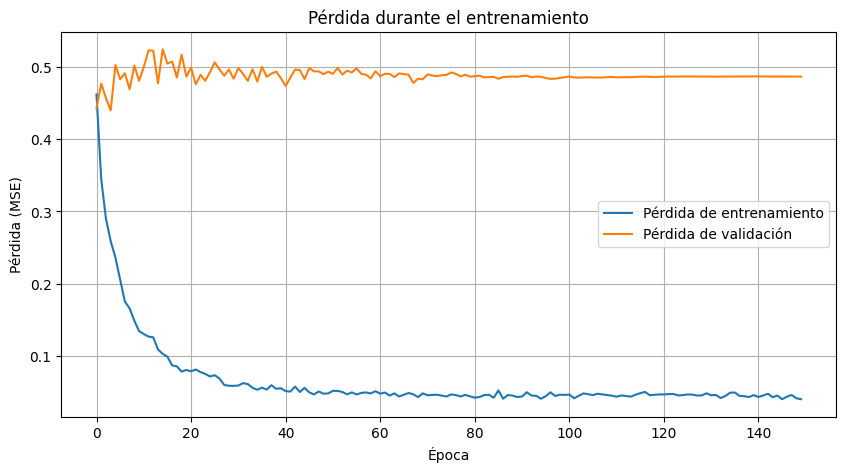

In [21]:
# -------------------------------
# 12. Graficar resultados
# -------------------------------
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Pérdida de entrenamiento')
plt.plot(val_losses, label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.show()



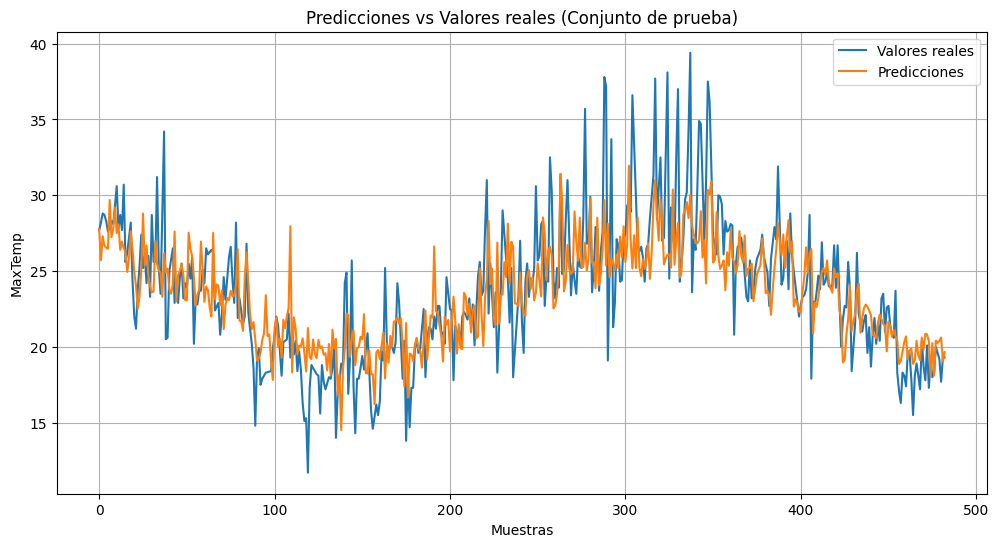

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Valores reales')
plt.plot(predictions, label='Predicciones')
plt.title('Predicciones vs Valores reales (Conjunto de prueba)')
plt.xlabel('Muestras')
plt.ylabel(target_col)
plt.legend()
plt.grid(True)
plt.show()



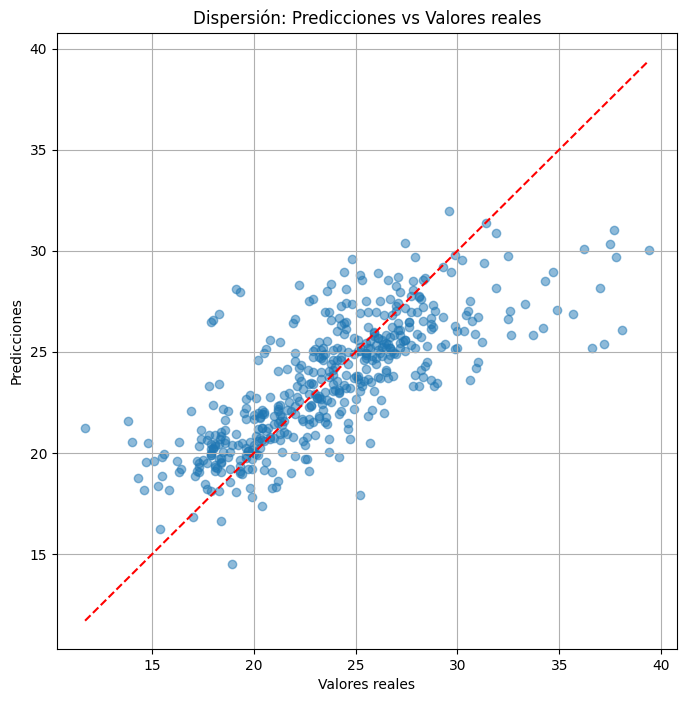

In [23]:
plt.figure(figsize=(8, 8))
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--')
plt.title('Dispersión: Predicciones vs Valores reales')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.grid(True)
plt.show()



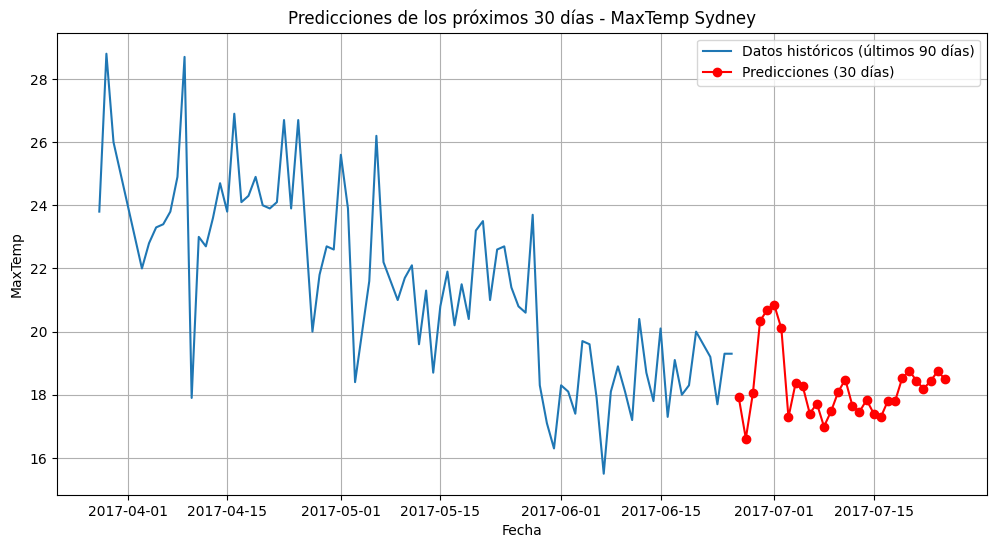

In [24]:
# -------------------------------
# 13. Predecir los próximos 30 días (autoregresivo)
# -------------------------------
# Usar la última secuencia como punto de partida
last_seq = X_norm[-seq_length:].copy()  # (seq_length, num_features)

# Realizar predicciones autoregresivas
model.eval()
future_predictions_norm = []
with torch.no_grad():
    for _ in range(30):
        inp_tensor = torch.tensor(last_seq.reshape(1, seq_length, num_features), dtype=torch.float32).to(device)
        pred_norm = model(inp_tensor).cpu().numpy()[0, 0]
        future_predictions_norm.append(pred_norm)

        # Actualizar la secuencia: desplazar y agregar nuevo timestep
        new_timestep = last_seq[-1].copy()  # Último vector de features
        new_timestep[target_idx] = pred_norm  # Actualizar solo el target
        last_seq = np.vstack((last_seq[1:], new_timestep.reshape(1, -1)))

# Desnormalizar
future_predictions_denorm = np.array(future_predictions_norm) * sigma_y + mu_y

# Crear fechas futuras
last_date = series.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')

# Gráfica de predicciones futuras
historical_end_idx = len(series) - 90
plt.figure(figsize=(12, 6))
plt.plot(series.index[historical_end_idx:], series[target_col][historical_end_idx:], label='Datos históricos (últimos 90 días)')
plt.plot(future_dates, future_predictions_denorm, 'ro-', label='Predicciones (30 días)')
plt.title('Predicciones de los próximos 30 días - MaxTemp Sydney')
plt.xlabel('Fecha')
plt.ylabel(target_col)
plt.legend()
plt.grid(True)
plt.show()

